**Инструкция по выполнению проекта**

- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить свёрточную свёрточную нейронную сеть на архитектуре ResNet и рассчитать её качество.
- Метрикой качества будет MAE меньше 8

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

import warnings

2023-11-19 09:23:34.666188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')

# 1 Preprocessing

**Data Preprocessing**

```python

train_directory = '/Users/kirillkasickij/Desktop/Python/CNN/faces/final_files/train'
test_directory = '/Users/kirillkasickij/Desktop/Python/CNN/faces/final_files/test'


def revert_file_names(directory):
    files = os.listdir(directory)

    for file_name in files:
        if file_name.endswith('_face.jpg'):
            new_file_name = file_name.replace('_face.jpg', '.jpg')
            os.rename(os.path.join(directory, file_name), os.path.join(directory, new_file_name))
            print(f'Reverted: {file_name} to {new_file_name}')

revert_file_names(train_directory)

revert_file_names(test_directory)


def remove_extra_extension(directory):
    files = os.listdir(directory)

    for file_name in files:
        if file_name.endswith('.jpg.jpg'):
            new_file_name = file_name.replace('.jpg.jpg', '.jpg')
            os.rename(os.path.join(directory, file_name), os.path.join(directory, new_file_name))
            print(f'Removed extra extension: {file_name} to {new_file_name}')

remove_extra_extension(train_directory)

remove_extra_extension(test_directory)

```

In [3]:
df_train = pd.read_csv('/Users/kirillkasickij/Desktop/Python/CNN/faces/gt_avg_train.csv')
df_train.head()

,file_name,num_ratings,apparent_age_avg,apparent_age_std,real_age
0,000000.jpg,36,5.000000,1.146423,4
1,000001.jpg,63,20.079365,4.096819,18
2,000002.jpg,38,76.815789,6.133009,80
3,000003.jpg,38,55.657895,7.864653,50
4,000004.jpg,15,17.666667,3.457222,17


In [4]:
df_test = pd.read_csv('/Users/kirillkasickij/Desktop/Python/CNN/faces/gt_avg_test.csv')
df_test.head()

,file_name,num_ratings,apparent_age_avg,apparent_age_std,real_age
0,005613.jpg,39,23.205128,5.530678,19
1,005614.jpg,38,70.736842,6.570549,76
2,005615.jpg,38,55.368421,5.874457,40
3,005616.jpg,36,24.277778,2.224681,21
4,005617.jpg,39,25.230769,5.691460,34


In [5]:
df_train = df_train[['file_name', 'real_age']]
df_test = df_test[['file_name', 'real_age']]

In [6]:
df_train.isna().sum()

file_name    0
real_age     0
dtype: int64

In [7]:
df_test.isna().sum()

file_name    0
real_age     0
dtype: int64

# 2 EDA

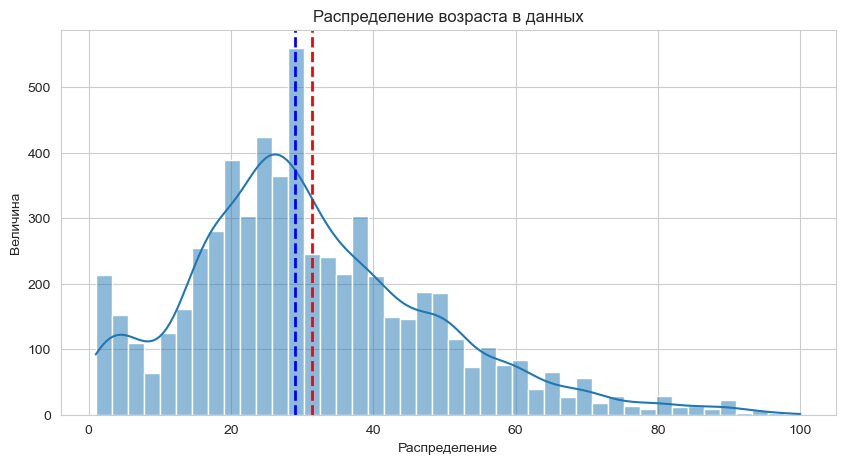

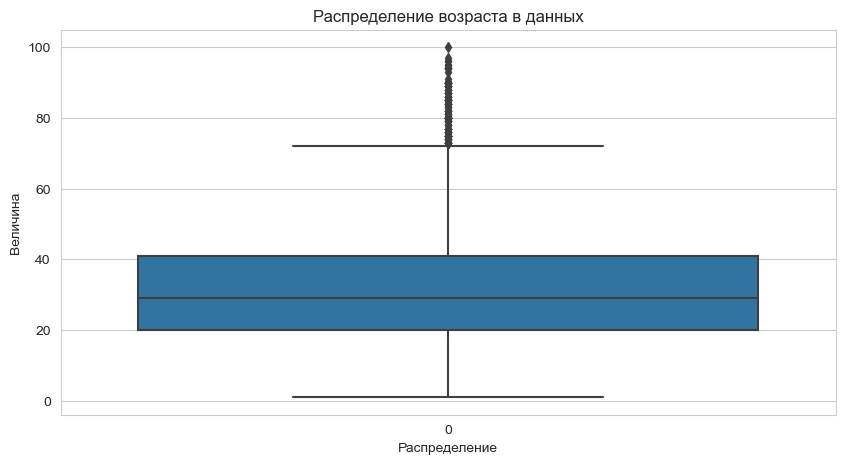

In [8]:
df_combined = pd.concat([df_train, df_test], ignore_index=True)

plt.figure(figsize=(10, 5))
sns.histplot(df_combined['real_age'], kde=True)

mean_age = df_combined['real_age'].mean()
median_age = df_combined['real_age'].median()
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Среднее: {mean_age:.2f}')
plt.axvline(median_age, color='blue', linestyle='dashed', linewidth=2, label=f'Медиана: {median_age:.2f}')

plt.ylabel('Величина')
plt.xlabel('Распределение')
plt.title('Распределение возраста в данных')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(df_combined['real_age'])
plt.ylabel('Величина')
plt.xlabel('Распределение')
plt.title('Распределение возраста в данных')
plt.show()

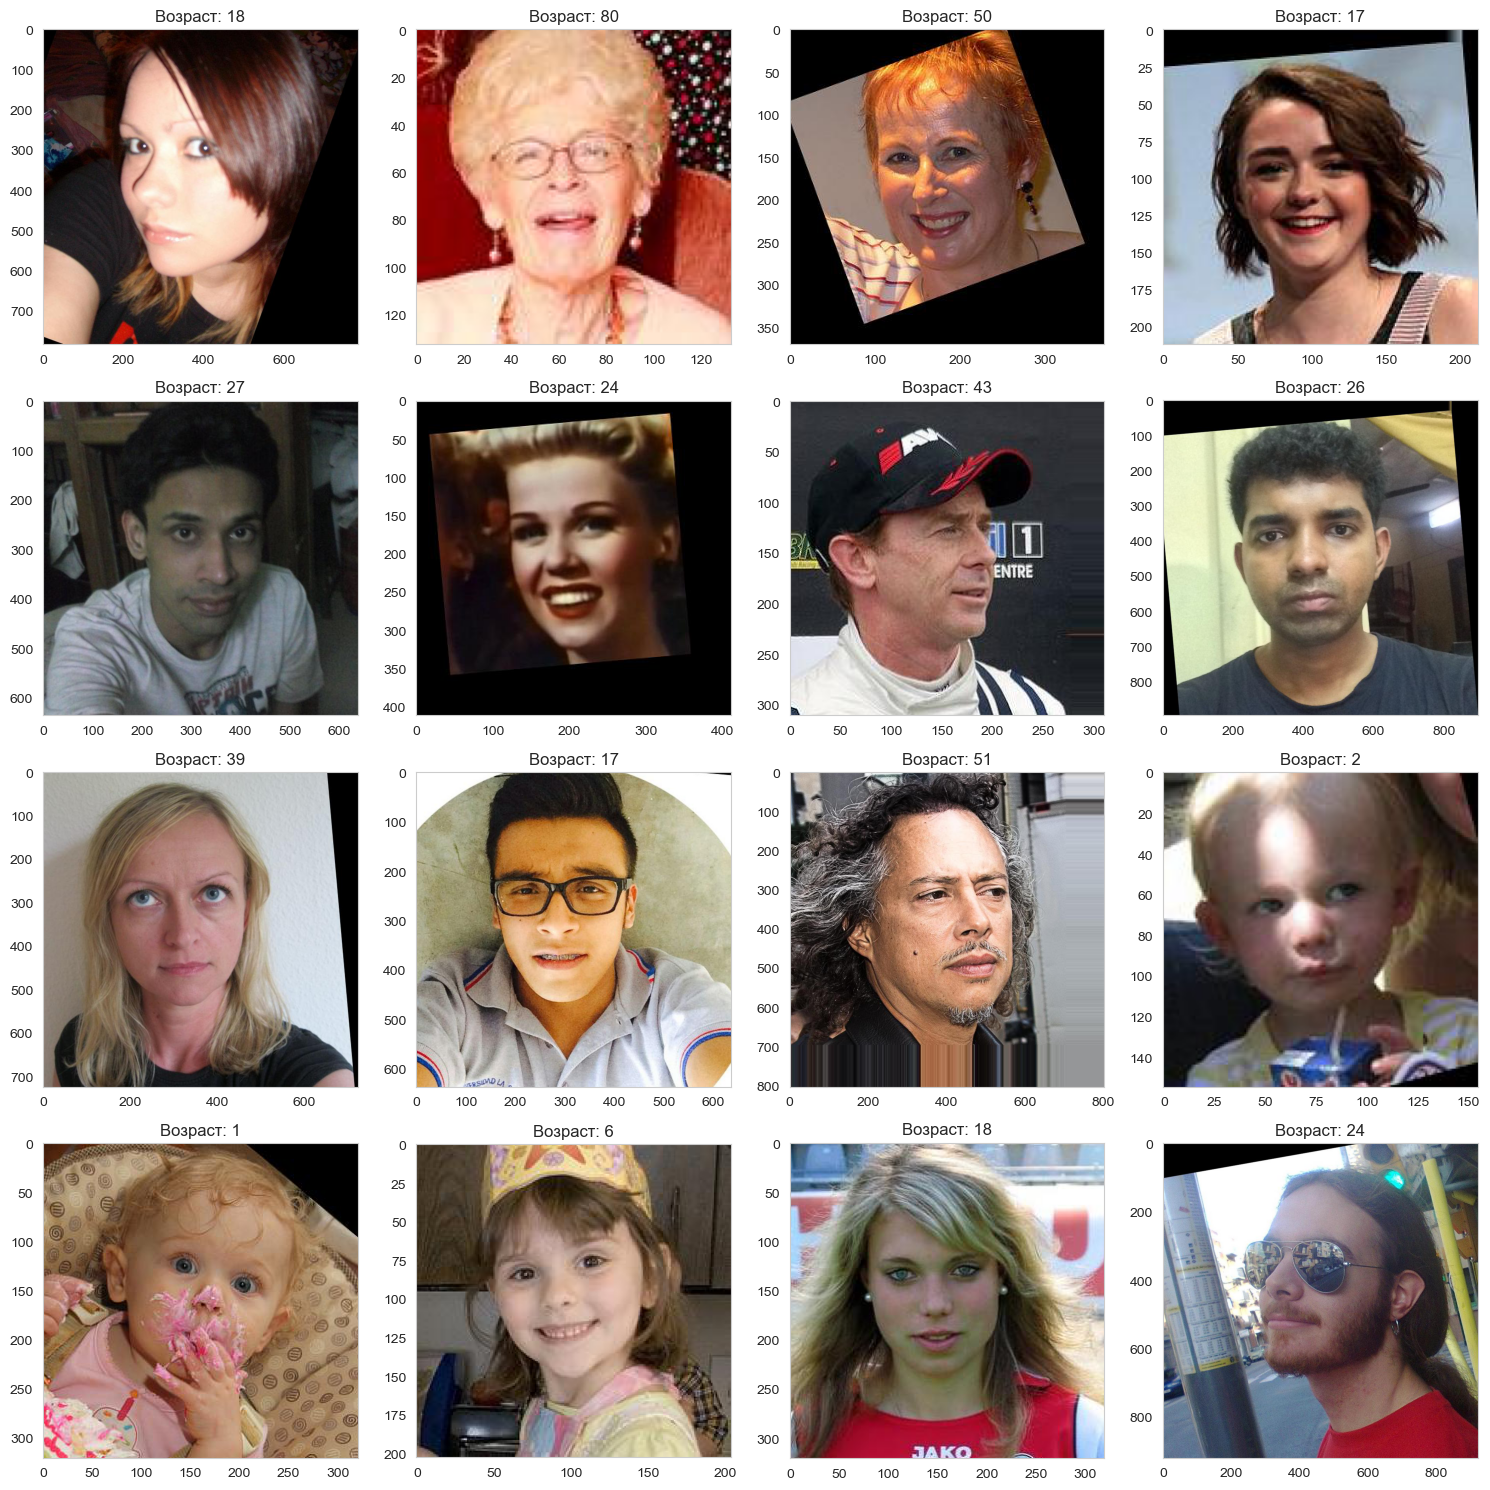

In [9]:
fig = plt.figure(figsize=(15, 15))

for i in range(1, 17):
    fig.add_subplot(4, 4, i)
    image_path = os.path.join('/Users/kirillkasickij/Desktop/Python/CNN/faces/final_files/train',
                              df_train.loc[i, 'file_name'])
    image = Image.open(image_path)
    
    plt.imshow(image)
    plt.grid(False)
    plt.tight_layout()
    plt.title(f'Возраст: {df_train.loc[i]["real_age"]}')

plt.show()

# 3 Model Creation

## 3.1 Data Loading

In [10]:
def load_train(path):
    labels = pd.read_csv(path + 'gt_avg_train.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/train/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        seed=2007,
        class_mode='raw',
        subset='training'
    )
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'gt_avg_test.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/test/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        seed=2007,
        class_mode='raw',
        subset='validation'
    )
    return test_datagen_flow

## 3.2 Model Creation

In [19]:
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0003)
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

## 3.3 Model Training

In [12]:
def train_model(model, train_data, test_data, batch_size, 
                epochs=15, steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True
    )
    return model

## 3.4 Teaching

In [13]:
train_data = load_train('/Users/kirillkasickij/Desktop/Python/CNN/faces/')
test_data = load_test('/Users/kirillkasickij/Desktop/Python/CNN/faces/')

Found 3085 validated image filenames.
Found 494 validated image filenames.


In [20]:
model = create_model(input_shape=(224, 224, 3))

In [21]:
batch_size = 32
steps_per_epoch = len(train_data) // batch_size  
validation_steps = len(test_data) // batch_size

model = train_model(model, train_data, test_data, batch_size=batch_size, epochs=15, 
                    steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/15
6/6 - 46s - loss: 941.1237 - mae: 26.6757 - 46s/epoch - 8s/step
Epoch 2/15
6/6 - 40s - loss: 472.7563 - mae: 17.9295 - 40s/epoch - 7s/step
Epoch 3/15
6/6 - 40s - loss: 316.6590 - mae: 14.3724 - 40s/epoch - 7s/step
Epoch 4/15
6/6 - 40s - loss: 148.4966 - mae: 9.3600 - 40s/epoch - 7s/step
Epoch 5/15
6/6 - 43s - loss: 172.7724 - mae: 10.1020 - 43s/epoch - 7s/step
Epoch 6/15
6/6 - 40s - loss: 146.7723 - mae: 9.1279 - 40s/epoch - 7s/step
Epoch 7/15
6/6 - 40s - loss: 162.9359 - mae: 10.3635 - 40s/epoch - 7s/step
Epoch 8/15
6/6 - 40s - loss: 177.6892 - mae: 9.7732 - 40s/epoch - 7s/step
Epoch 9/15
6/6 - 41s - loss: 165.8371 - mae: 9.2317 - 41s/epoch - 7s/step
Epoch 10/15
6/6 - 42s - loss: 155.3091 - mae: 9.1138 - 42s/epoch - 7s/step
Epoch 11/15
6/6 - 40s - loss: 168.4102 - mae: 10.0302 - 40s/epoch - 7s/step
Epoch 12/15
6/6 - 40s - loss: 132.2882 - mae: 9.2550 - 40s/epoch - 7s/step
Epoch 13/15
6/6 - 40s - loss: 102.7143 - mae: 7.8004 - 40s/epoch - 7s/step
Epoch 14/15
6/6 - 41s - loss

Модель научилась определять возраст по фото с погрешностью в 7 лет